# Predicting Amazon Review Ratings from Text

This project uses natural language processing (NLP) to classify Amazon product reviews based on written content alone to identify how much a review’s language reflects customer satisfaction. By training a supervised classification model, we aim to turn review text into insight — for review moderation, customer feedback analysis, and quality control.

We'll be using the [Amazon Product Reviews](https://www.kaggle.com/datasets/divyaprakashr/amazon-products) dataset which contains product review data including:

- `text`: the main review content (free-form text)
- `rating`: the review’s star rating (1 to 5 stars)
- `product_category`: the category of the reviewed product
- `verified_purchase`: whether the review is from a verified purchase
- `helpful_votes`: number of users who found the review helpful

### Imports
Below we have included all package imports used throughout the project. 

In [1]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # plotting
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # turn warnings off

import emoji # to see if a text contains an emoji

from sklearn.feature_extraction.text import CountVectorizer # to create our bigram

from textblob import TextBlob # to analyze the sentiment of text

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from nltk.corpus import stopwords
import spacy
from gensim.models.phrases import Phraser

import re 

from gensim.corpora import Dictionary

from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import pearsonr # correlation

# modeling prediction
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Before modeling, we begin with an initial exploration of the dataset.

## Data Cleaning

### Reviews Dataset
- Read in the reviews dataset using `pandas`  
- Selected relevant columns, including:
  - `review_text` — the text content of each review
  - `rating` — the target variable (1–5 star rating)
- Checked for missing values to ensure data quality
- Inspected unique values in key columns to understand the rating scale and data consistency

This exploration confirmed the presence of five distinct rating classes (1 to 5 stars) and revealed some class imbalance — with most reviews concentrated in the 4–5 star range.

In [2]:
# read data
reviews = pd.read_csv('/kaggle/input/amazon-products/amazon_product_metadata.csv', index_col=0) # there is a pre-existing index col

# print the first few rows
reviews.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4,No white background! It’s clear!,I bought this bc I thought it had the nice whi...,[{'small_image_url': 'https://images-na.ssl-im...,B08L6L3X1S,B08L6L3X1S,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2021-01-30 22:07:31.196,0,True
1,5,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...,[],B079BPGF6C,B079BPGF6C,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2018-08-16 18:18:37.349,2,True
2,5,Worked but took an hour to install,Overall very happy with the end result. If you...,[{'small_image_url': 'https://m.media-amazon.c...,B088DR7Z5B,B0BBGGC8F2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2021-08-17 21:21:44.798,3,True


In [3]:
# get information about the columns and shape
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   rating             500000 non-null  int64 
 1   title              499877 non-null  object
 2   text               499854 non-null  object
 3   images             500000 non-null  object
 4   asin               500000 non-null  object
 5   parent_asin        500000 non-null  object
 6   user_id            500000 non-null  object
 7   timestamp          500000 non-null  object
 8   helpful_vote       500000 non-null  int64 
 9   verified_purchase  500000 non-null  bool  
dtypes: bool(1), int64(2), object(7)
memory usage: 38.6+ MB


There are 10 columns and 500000 rows of data in the reviews dataset. Most of the columns in the reviews dataset are objects (text). rating and helpful_vote are integers, and verified_purchase is boolean (yes/no). 

title and text are the only columns with null values. This makes sense because some users may leave a review with only a star rating. Our purpose is to gain Customer Insight based on the review they've left. We will include these ratings for our analysis, but will likely drop them before modeling. 

In [4]:
# get the summary information for the non-categorical columns
reviews.describe()

,rating,helpful_vote
count,500000.000000,500000.000000
mean,4.145878,0.663038
std,1.344091,7.375578
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,1127.000000


The average rating in the dataset is 4.14 which is pretty high. Let's compare it to our median.

In [5]:
# median rating
reviews.rating.median()

5.0

The median is higher than the mean. This usually indicates a left-skew (most of the data is clustered towards the higher end of reviews). 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


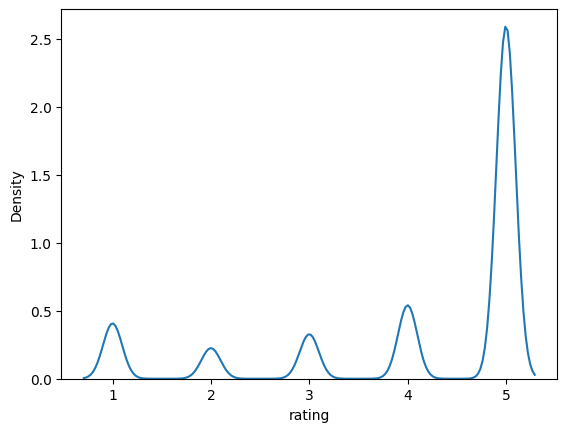

In [6]:
# plot the rating distribution
sns.kdeplot(data=reviews, x='rating')
plt.show()

We have an overwhelming amount of 5-star reviews in the dataset causing a left-skew as we expected based on the mean and median.

### Reviews without text

In [7]:
# find the null values in the text column
# list of values to replace
na_values_to_replace = ['Na','na','none','-','N//A','NONE','N/A.',' ','N/a','None.',',...,,',np.nan,None]

# replace those values with an empty string
reviews['text'] = reviews['text'].replace(na_values_to_replace, '', regex=False)

# replace values that are actual missing (NaN) with .fillna()
reviews['text'] = reviews['text'].fillna('')

# get a sorted list of the text by length
sorted(reviews.text.unique(), key=len)[:8]

['', '👍', '😀', '✔', '😊', '🤩', '😍', '😁']

By looking at the reviews, we can see that there are a lot that have emojis or symbols in the text rather than actual words. We'll review that later on in our project.

### New Columns
For now, we'll create some new variables based on what is and isn't in the text.

In [8]:
# create a column to represent whether the review has text
reviews['has_text'] = reviews['text'].apply(lambda x: 0 if x.strip() == '' else 1)

# get the value counts
reviews.has_text.value_counts()

has_text
1    499630
0       370
Name: count, dtype: int64

There are only 370 reviews in this dataset that do not have some sort of text. text is not constrained to words. It can be emojis or characters that convey emotion.

In [9]:
# new column to represent the number of characters in the text
reviews['num_char'] = reviews['text'].apply(lambda x: len(x))
# print a few out
reviews.loc[:, ['text', 'num_char']].sort_values(by='num_char', ascending = False).head(5)

,text,num_char
272526,Originally bought 1/28/2014. Amazon changed th...,17098
404929,FULL DETAIL Treo review with UPGRADE DETAILS!!...,13155
344627,NOTE about this particular model: This particu...,12363
345997,======================================<br />Su...,11775
2890,For clarification: I purchased this case in th...,10673


Our reviews have up to 17,098 characters in their text. 

In [10]:
# does the text have emojis
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in text)

# apply to the dataframe
reviews['has_emoji'] = reviews['text'].apply(lambda x: contains_emoji(str(x)))
# print a few rows
reviews[reviews.has_emoji == 1].head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,has_text,num_char,has_emoji
107,5,Durable t,This is my 3rd case. Every time I get a new ph...,[],B08V7BQ9ZF,B092RP9K4Q,AH6CATODIVPVUOJEWHRSRCSKAOHA,2022-07-25 16:24:55.349,0,True,1,333,True
108,5,Great phone case,Great case for my phone. Looks good and is stu...,[],B07J6QR15S,B07J6QR15S,AH6CATODIVPVUOJEWHRSRCSKAOHA,2020-01-05 18:28:00.846,0,True,1,147,True
190,5,Convenient,I absolutely love this. I only want this purpl...,[],B08Z7LP22F,B09GB7M3R6,AE72A3F2N3PVD4CJM527Z4N6CN2A,2022-05-30 15:48:10.673,0,True,1,101,True
302,4,Phone cases,"They are adorable 💕, however not very heavy or...",[],B09S5TS4XY,B09S5TS4XY,AFSNGBROR4NUCU6UQCJBB4VEJOPA,2022-10-30 14:40:22.316,0,True,1,178,True
538,1,Never charged up,"Unfortunately, mine doesn't get charged up. Wa...",[],B09NXPHQVL,B0BVZQ2QHM,AHNTNORB4V4WEELIYXTSKV56Y4AA,2023-03-12 04:06:27.906,0,True,1,59,True


In [11]:
# get the number of emojis in the text
def count_emojis(text):
    if not isinstance(text, str):
        return 0
    return sum(1 for char in text if char in emoji.EMOJI_DATA)

# apply function to dataset
reviews['num_emoji'] = reviews['text'].apply(count_emojis)

# print a few rows
reviews[reviews.num_emoji > 1].head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,has_text,num_char,has_emoji,num_emoji
927,5,Great product!,[[VIDEOID:57233135e36419cd153c6a4ea7280068]] A...,[{'small_image_url': 'https://images-na.ssl-im...,B097PNXGBK,B097PNXGBK,AHCWHNTFHR4T2SG7JXIJOT5PA6NA,2021-07-19 18:03:58.170,0,True,1,145,True,3
1230,5,Just Perfect,This phone is exactly as stated. Too bad no fi...,[],B0BJVYWWK2,B0C171QJLF,AHQ5LUB5SXGXMH3AQEYW67LDSL2A,2023-01-05 01:43:02.052,5,True,1,216,True,2
1580,5,👍👍,👍👍,[],B081GYSPVM,B0BZPB1GXV,AHBZRDFYB2FWUAO63DCSF2VSTJ2Q,2020-11-20 16:18:43.449,0,True,1,2,True,2
1581,5,👍👍,👍👍,[],B0832DFNWX,B0832DFNWX,AHBZRDFYB2FWUAO63DCSF2VSTJ2Q,2020-11-20 16:16:38.772,0,True,1,2,True,2
1583,4,👍👍,👍👍,[],B06XGWZX85,B06XGWZX85,AHBZRDFYB2FWUAO63DCSF2VSTJ2Q,2020-01-10 22:11:43.482,0,True,1,2,True,2


In [12]:
# create a column to represent whether the review has an image
reviews['has_image'] = reviews['images'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '[]' else 1)

# get the value counts
reviews.has_image.value_counts()

has_image
0    477613
1     22387
Name: count, dtype: int64

In [13]:
# create a new variable to represent whether the review was considered helpful
reviews['helpful'] = reviews['helpful_vote'].apply(lambda x: x > 0)

In [14]:
# change the timestamp column to datetime
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], errors='coerce')
# print a few
reviews.timestamp.min()

Timestamp('2001-11-12 14:36:43')

In [15]:
# add columns for month/day/year
reviews['month'] = reviews.timestamp.dt.month
reviews['day'] = reviews.timestamp.dt.day
reviews['year'] = reviews.timestamp.dt.year
reviews['time'] = reviews.timestamp.dt.time

In [16]:
# output our new dataset
reviews.to_csv('reviews.csv')

### Products Dataset
Now that we've cleaned and explored the reviews dataset, we turn our attention to the **product metadata** where we 
- Load and preview the product dataset
- Handle missing or inconsistent values
- Explore unique product categories
- Prepare the data for merging or downstream analysis

This dataset contains product-level information such as:
- `product_id` — unique identifier for each product
- `product_category` — category label for grouping products

This step helps enrich our review data with category-level context, which may be useful for grouping, filtering, or future modeling work.

In [17]:
# read the metadata
products = pd.read_csv('/kaggle/input/amazon-products/amazon_metadata.csv', index_col = 0)

# print a few rows
products.head(3)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Cell Phones & Accessories,ARAREE Slim Diary Cell Phone Case for Samsung ...,3.8,5,['Genuine Cow leather with 6 different colors'...,"[""JUST LOOK, You can tell the difference. Make...",NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],araree,"['Cell Phones & Accessories', 'Cases, Holsters...",{'Product Dimensions': '3.35 x 0.59 x 6.18 inc...,B013SK1JTY,NaN,NaN,NaN
1,Cell Phones & Accessories,Bastmei for OnePlus 7T Case Extremely Light Ul...,4.4,177,['Ultra-thin & Ultra-light: The ultra slim fit...,[],11.98,[{'thumb': 'https://m.media-amazon.com/images/...,[],Bastmei,"['Cell Phones & Accessories', 'Cases, Holsters...",{'Package Dimensions': '7.6 x 4.29 x 0.75 inch...,B07ZPSG8P5,NaN,NaN,NaN
2,Cell Phones & Accessories,Wireless Fones Branded New Iphone 5C/LITE Hot ...,4.0,2,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],WIRELESS FONES,"['Cell Phones & Accessories', 'iPhone Accessor...","{'Item model number': 'Apple Iphone 5C', 'Othe...",B00GKR3L12,NaN,NaN,NaN


In [18]:
# print the information on the columns
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    499019 non-null  object 
 1   title            499931 non-null  object 
 2   average_rating   500000 non-null  float64
 3   rating_number    500000 non-null  int64  
 4   features         500000 non-null  object 
 5   description      500000 non-null  object 
 6   price            127563 non-null  object 
 7   images           500000 non-null  object 
 8   videos           500000 non-null  object 
 9   store            493569 non-null  object 
 10  categories       500000 non-null  object 
 11  details          500000 non-null  object 
 12  parent_asin      500000 non-null  object 
 13  bought_together  0 non-null       float64
 14  subtitle         683 non-null     object 
 15  author           9 non-null       object 
dtypes: float64(2), int64(1), object(13)
memory 

There are more columns in this dataset that have null values: main_category, title, price, store, bought_together, subtitle, and author. bought_together and author have very few non-null values. We'll drop these columns from our dataset. 

In [19]:
# drop bought_together and author
products.drop(['bought_together', 'author'], axis = 1, inplace = True)

In [20]:
# get a list of the Product categories
products.main_category.unique()

array(['Cell Phones & Accessories', 'Sports & Outdoors',
       'All Electronics', 'AMAZON FASHION', 'Computers', 'Amazon Home',
       'Industrial & Scientific', 'Office Products', 'Camera & Photo',
       'Portable Audio & Accessories', nan, 'Home Audio & Theater',
       'Fire Phone', 'Books', 'Automotive', 'Musical Instruments',
       'Video Games', 'Tools & Home Improvement',
       'Health & Personal Care', 'Amazon Devices', 'Baby',
       'Arts, Crafts & Sewing', 'Grocery', 'All Beauty', 'Apple Products',
       'Pet Supplies', 'Toys & Games', 'Entertainment', 'Movies & TV',
       'GPS & Navigation', 'Car Electronics', 'Handmade',
       'Collectible Coins', 'Software', 'Appliances', 'Digital Music',
       'Amazon Fire TV', 'Collectibles & Fine Art', 'Audible Audiobooks',
       'Buy a Kindle'], dtype=object)

There are 39 unique values in the main_category column (cardinality = 39). Let's see if we can condense some of these categories. 

In [21]:
# new dictionary with more generalized categories
new_categories = {
	'electronics': ['Cell Phones & Accessories', 'All Electronics', 'Computers', 'Camera & Photo', 'Portable Audio & Accessories', 'Home Audio & Theater', 'GPS & Navigation', 'Car Electronics', 'Amazon Fire TV', 'Apple Products', 'Fire Phone', 'Amazon Devices','Software'],
	'fashion': ['AMAZON FASHION'],
	'home': ['Amazon Home', 'Tools & Home Improvement', 'Appliances'],
	'office': ['Industrial & Scientific', 'Office Products'],
	'media': ['Books', 'Audible Audiobooks', 'Buy a Kindle', 'Entertainment','Movies & TV','Digital Music'],
	'outdoors': ['Sports & Outdoors'],
	'play': ['Toys & Games','Video Games'],
	'auto': ['Automotive'],
	'instruments': ['Musical Instruments'],	
	'personal': ['Health & Personal Care', 'All Beauty'],
	'baby': ['Baby'],
	'craft': ['Arts, Crafts & Sewing', 'Handmade'],
	'food': ['Grocery'],
	'pet': ['Pet Supplies'],
	'collect': ['Collectible Coins', 'Collectibles & Fine Art'],
	'Other': [np.nan]
}

# invert the new_categories dictionary
category_mapping = {orig: new for new, originals in new_categories.items() for orig in originals}

# Apply to your DataFrame (assuming the column is named 'category')
products['category'] = products['main_category'].map(category_mapping)

# check for nas
products.category.isna().sum()

0

In [22]:
# check to see if there are any rows that have a subtitle but not a title
products[products.subtitle.notna() & products.title.isna()]

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,subtitle,category


## Merge our datasets

In [23]:
# merging the datasets
product_reviews = reviews.merge(products, on='parent_asin', how='left')

# print a few rows
product_reviews.head(3)

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,features,description,price,images_y,videos,store,categories,details,subtitle,category
0,4,No white background! It’s clear!,I bought this bc I thought it had the nice whi...,[{'small_image_url': 'https://images-na.ssl-im...,B08L6L3X1S,B08L6L3X1S,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2021-01-30 22:07:31.196,0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...,[],B079BPGF6C,B079BPGF6C,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2018-08-16 18:18:37.349,2,True,...,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Fitian,"['Cell Phones & Accessories', 'Accessories', '...",{'Package Dimensions': '4.5 x 2.4 x 0.4 inches...,NaN,electronics
2,5,Worked but took an hour to install,Overall very happy with the end result. If you...,[{'small_image_url': 'https://m.media-amazon.c...,B088DR7Z5B,B0BBGGC8F2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2021-08-17 21:21:44.798,3,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# determine nulls on combination
product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             500000 non-null  int64         
 1   title_x            499877 non-null  object        
 2   text               500000 non-null  object        
 3   images_x           500000 non-null  object        
 4   asin               500000 non-null  object        
 5   parent_asin        500000 non-null  object        
 6   user_id            500000 non-null  object        
 7   timestamp          500000 non-null  datetime64[ns]
 8   helpful_vote       500000 non-null  int64         
 9   verified_purchase  500000 non-null  bool          
 10  has_text           500000 non-null  int64         
 11  num_char           500000 non-null  int64         
 12  has_emoji          500000 non-null  bool          
 13  num_emoji          500000 non-null  int64   

In [25]:
# let's rename the columns so they're clear
product_reviews = product_reviews.rename(columns={'title_x':'title', 'images_x':'images', 'asin':'product_sub_id', 'parent_asin':'product_id', 'title_y':'product_title'
                                                , 'average_rating':'product_avg_rating', 'rating_number':'num_ratings', 'images_y':'product_images'})

In [26]:
product_reviews.columns

Index(['rating', 'title', 'text', 'images', 'product_sub_id', 'product_id',
       'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'has_text',
       'num_char', 'has_emoji', 'num_emoji', 'has_image', 'helpful', 'month',
       'day', 'year', 'time', 'main_category', 'product_title',
       'product_avg_rating', 'num_ratings', 'features', 'description', 'price',
       'product_images', 'videos', 'store', 'categories', 'details',
       'subtitle', 'category'],
      dtype='object')

Below is an outline of our combined dataset which we will use for our analysis. 

|Title|Description|Type|Range|Notes|
|----|----|----|----|----|
|rating|rating by user|int|1-5|| 
|title|rating title by user|object||| 
|text|rating text by user|object||| 
|images|list of rating images by user|object||| 
|product_sub_id|id given to product variation such as having a different color|object||| 
|product_id|id give to each product|object|||
|user_id|id of user that submitted rating|object||| 
|timestamp|date and time of rating|datetime||| 
|helpful_vote|number of people that found the rating helpful|int|0-|| 
|verified_purchase|whether the purchase was verified|bool||| 
|has_text|whether the review has text||||
|num_char|number of characters in the text|||| 
|has_emoji|whether the text has emojis|||| 
|num_emoji|number of emojis in the text|||| 
|helpful|whether the review was helpful|||| 
|month|month review was submitted|||| 
|day|day review was submitted|||| 
|year|year review was submitted||||
|time|time review was submitted|||| 
|has_image|whether the review has an image|||| 
|main_category|product category|||| 
|product_title|product title||||
|product_avg_rating|average rating for product|||| 
|num_ratings|number of ratings for product|||| 
|features|feature attributes of product|||| 
|description|description of product|||| 
|price|price of product||||
|product_images|images for product|||| 
|videos|videos for product|||| 
|store|store name selling product|||| 
|categories|condensed categories for product|||| 
|details|details for product||||
|subtitle|product subtitle|||| 
|category|product category|||| 

## Exploration
Before modeling, we explored the distribution of review ratings and basic text characteristics.

### Rating Distribution
- The majority of reviews are 4 or 5 stars, suggesting a **positive bias** in the dataset.
- 1-star and 2-star reviews are underrepresented, creating a **class imbalance** challenge for classification models.

### Review Text Insights
- We explored the length of reviews (in words/characters) and found that longer reviews tend to appear more in lower or higher ratings.

These insights help guide preprocessing and model evaluation decisions — particularly regarding the need for balancing techniques and evaluation metrics that account for skewed class distributions.

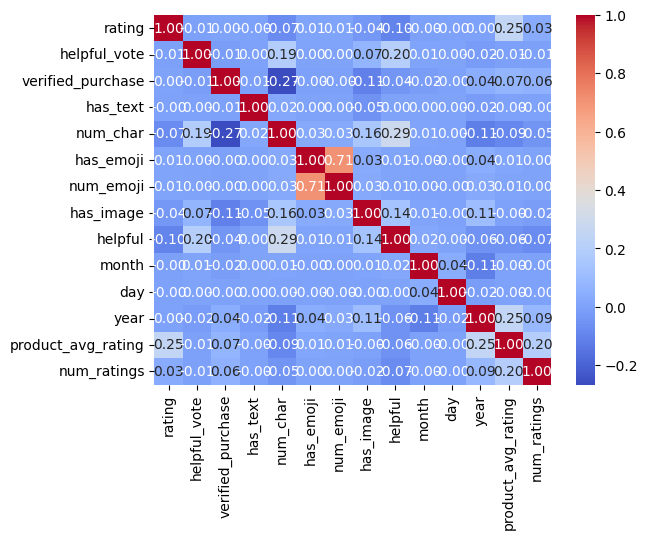

In [27]:
# what is the correlation (linear relationship) between our variables?
corr_matrix = product_reviews.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

There are a few takeaways from this correlation heatmap. None of the variables have an explicitly high linear relationship apart from num_emoji and has_emoji which we expect to be high as they both relate to the emojis in the text column.

This does not mean that the fields do not have a relationship, but rather that they don't have a strong linear relationship. Here are some of the stronger relationships from our output:
- ratings with more characters tend to be considered helpful (num_char with helpful	= 0.29)
- products with more reviews seem to have higher ratings (rating with product_avg_ratings = 0.25)
- the product average rating tends to increase with the year (year with product_avg_rating = 0.25)
- reviews with images tend to also have more text (num_char with has_image = 0.16)
- reviews with images tend to be considered helpful (has_image with helpful	= 0.14)
- the number of characters tend to decrease as the years go on (num_char with year = -0.11)
- verified purchases tend to have fewer characters (verified_purchase with num_char = -0.27)
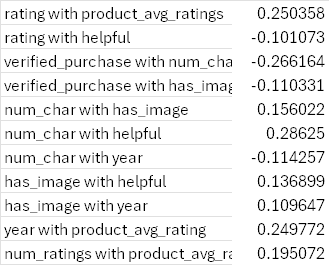
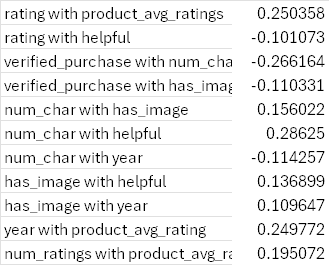
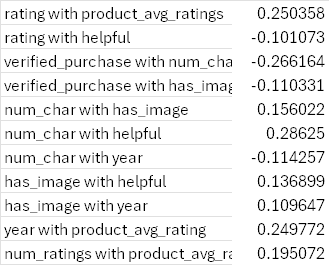
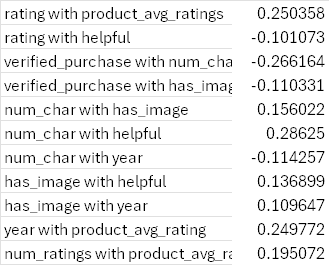

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


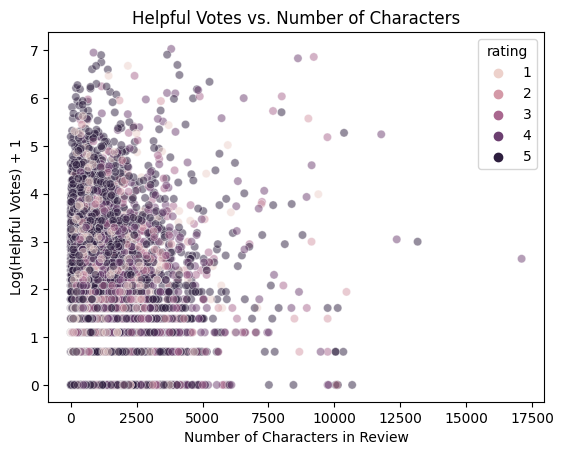

In [28]:
# plot the number of characters vs the indicator as to whether the vote was helpful
sns.scatterplot(data=product_reviews, x='num_char', y=np.log(product_reviews['helpful_vote'] + 1), hue='rating', alpha=0.5)
plt.title('Helpful Votes vs. Number of Characters')
plt.xlabel('Number of Characters in Review')
plt.ylabel('Log(Helpful Votes) + 1')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


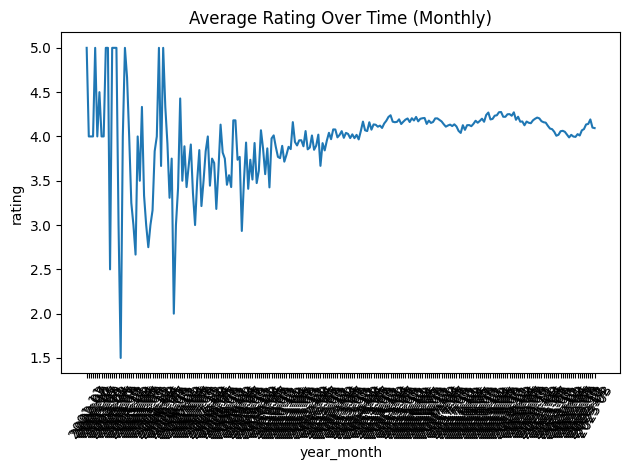

In [29]:
# plot the average rating over time
# create a monthly period column
product_reviews['year_month'] = product_reviews['timestamp'].dt.to_period('M')

# group and plot
monthly_avg = product_reviews.groupby('year_month')['rating'].mean().reset_index()
monthly_avg['year_month'] = monthly_avg['year_month'].astype(str)

sns.lineplot(data=monthly_avg, x='year_month', y='rating')
plt.xticks(rotation=60)
plt.title('Average Rating Over Time (Monthly)')
plt.tight_layout()

There are 23 years of reviews in our dataset (276 months). We'll smooth it out so we can see the trend over the years.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/relational.py:441: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupi

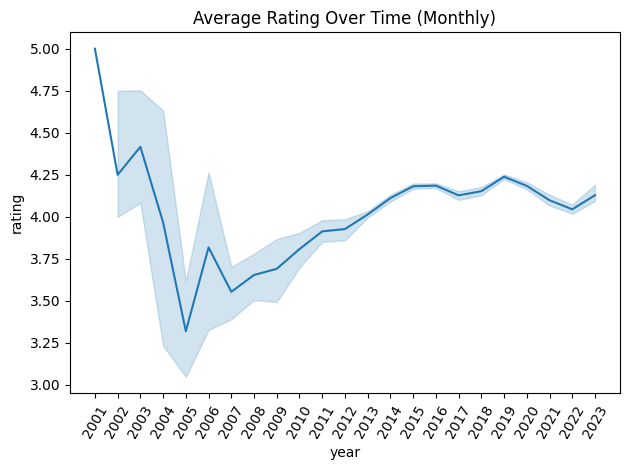

In [30]:
# create a monthly period column
product_reviews['year_month'] = product_reviews['timestamp'].dt.to_period('M')

# group and plot
monthly_avg = product_reviews.groupby('year_month')['rating'].mean().reset_index()
monthly_avg['year_month'] = monthly_avg['year_month'].astype(str)

# extract just the year for xticks
monthly_avg['year'] = monthly_avg['year_month'].str[:4]

# plot the data
sns.lineplot(data=monthly_avg, x='year', y='rating')
plt.xticks(rotation=60)
plt.title('Average Rating Over Time (Monthly)')
plt.tight_layout()

Based on our plot, the average ratings have overall been increasing over the years. We saw a peak in 2019 during covid, a steady decline to 2022, then ratings started to pick back up around 2023. 

## Text Preprocessing

To prepare the review text for modeling, in this section we applied a series of standard NLP preprocessing steps:
- Converted all text to lowercase
- Removed punctuation and special characters
- Removed stopwords (e.g., "the", "and", "is")
- Tokenized text (split into individual words)
- Optionally lemmatized or stemmed words to reduce them to base form

These steps help reduce noise and ensure that different versions of the same word are treated consistently.

#### TF-IDF
I used the **TF-IDF (Term Frequency–Inverse Document Frequency)** technique to convert cleaned text into numerical feature vectors. This method captures the importance of each word relative to how common it is across all reviews — emphasizing words that carry meaningful signals about the review's sentiment or rating. The resulting matrix is used as input to our machine learning models.

In [31]:
# define a list of english stop words
basic_stopwords = set([
    'the', 'and', 'is', 'in', 'to', 'of', 'a', 'for', 'this', 'it', 'on', 'with', 'was', 'as',
    'that', 'but', 'are', 'not', 'be', 'have', 'at', 'or', 'an', 'if', 'my', 'they', 'so', 'we'
])

# create a function that will clean 
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in basic_stopwords]
    return ' '.join(tokens)

# apply to dataset
product_reviews['cleaned_text'] = product_reviews['text'].apply(preprocess_text)

# print a few rows
print(product_reviews.loc[0, ['text', 'cleaned_text']])

text            I bought this bc I thought it had the nice whi...
cleaned_text    i bought bc i thought had nice white backgroun...
Name: 0, dtype: object


### What are the most common words or phrases in 5-star vs 1-star reviews?

We'll only use 5 and 1 star reviews to see the biggest contrast. 

In [32]:
# get 5 and 1 star ratings only
pr_5 = product_reviews[product_reviews['rating'] == 5]
pr_1 = product_reviews[product_reviews['rating'] == 1]

In [33]:
# get word frequencies
# initialize vectorizer
# vectorizer = CountVectorizer(max_features=50)  # top 50 most frequent words
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=50)

# fit and transform
X_5 = vectorizer.fit_transform(pr_5['cleaned_text'])
X_1 = vectorizer.fit_transform(pr_1['cleaned_text'])

# get word counts
word_counts_5 = np.asarray(X_5.sum(axis=0)).flatten()
word_counts_1 = np.asarray(X_1.sum(axis=0)).flatten()

# get words
words_5 = vectorizer.get_feature_names_out()
words_1 = vectorizer.get_feature_names_out()

# create dataframes
freq_5 = pd.DataFrame({'word': words_5, 'count': word_counts_5}).sort_values(by='count', ascending=False)
freq_1 = pd.DataFrame({'word': words_1, 'count': word_counts_1}).sort_values(by='count', ascending=False)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

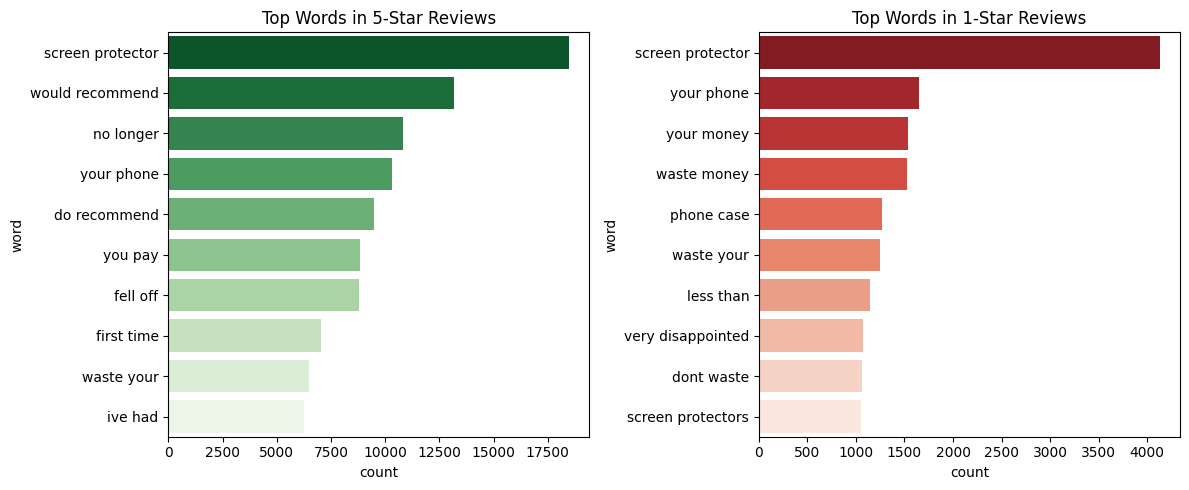

In [34]:
# plot the result
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=freq_5.head(10), x='count', y='word', palette='Greens_r')
plt.title('Top Words in 5-Star Reviews')

plt.subplot(1, 2, 2)
sns.barplot(data=freq_1.head(10), x='count', y='word', palette='Reds_r')
plt.title('Top Words in 1-Star Reviews')

plt.tight_layout()
plt.show()

From our output, we can see there are stopwords that made it in such as your or ive. We can update our stopword removal to get a better read on the words being used. 

In [35]:
# create new stopword list
extra_stopwords = set([
    'ive', 'im', 'youre', 'youve', 'youll', 'id', 'you', 'your', 'yours', 
    'dont', 'doesnt', 'didnt', 'cant', 'couldnt', 'wont', 'wasnt', 'isnt', 
    'also', 'one', 'get', 'got', 'still', 'even', 'really', 'much', 'would', 
    'could', 'thing', 'things', 'make', 'made', 'their', 'there', 'theyre', 'do', 'did'
])

# merge with original set
custom_stopwords = basic_stopwords.union(extra_stopwords)

# update function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]
    return ' '.join(tokens)

# apply to dataset
product_reviews['cleaned_text'] = product_reviews['text'].apply(preprocess_text)

In [36]:
# regenerate bigram plot
# get 5 and 1 star ratings only
pr_5 = product_reviews[product_reviews['rating'] == 5]
pr_1 = product_reviews[product_reviews['rating'] == 1]

def get_top_ngrams(corpus, n=20):
    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=1000)
    X = vectorizer.fit_transform(corpus)
    counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    ngram_freq = pd.DataFrame({'bigram': vocab, 'count': counts})
    return ngram_freq.sort_values(by='count', ascending=False).head(n)

top_5_bigrams = get_top_ngrams(pr_5['cleaned_text'], n=15)
top_1_bigrams = get_top_ngrams(pr_1['cleaned_text'], n=15)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

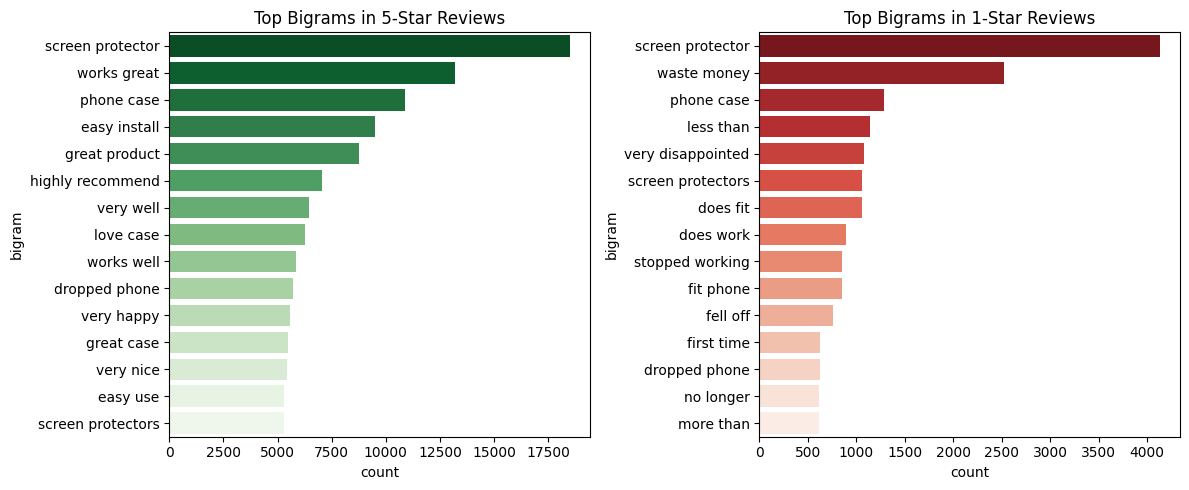

In [37]:
# plot result
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=top_5_bigrams, x='count', y='bigram', palette='Greens_r')
plt.title('Top Bigrams in 5-Star Reviews')

plt.subplot(1, 2, 2)
sns.barplot(data=top_1_bigrams, x='count', y='bigram', palette='Reds_r')
plt.title('Top Bigrams in 1-Star Reviews')

plt.tight_layout()
plt.show()

Now that we have added more stop words, we start to see a stronger distiction in the tone used for postive (5) vs negative (1) ratings. Next, we will compare the sentiment score of the text with the rating of the review. 

### Can sentiment analysis of reviews predict star rating?

In [38]:
# define a function for textblob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Range: [-1, 1]

# apply to the cleaned text in our database
product_reviews['sentiment_score'] = product_reviews['cleaned_text'].apply(get_sentiment)

# print a few
product_reviews.loc[:5, ['rating', 'sentiment_score']]

,rating,sentiment_score
0,4,0.240000
1,5,0.125000
2,5,0.363740
3,4,-0.216667
4,5,0.325000
5,5,0.560000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


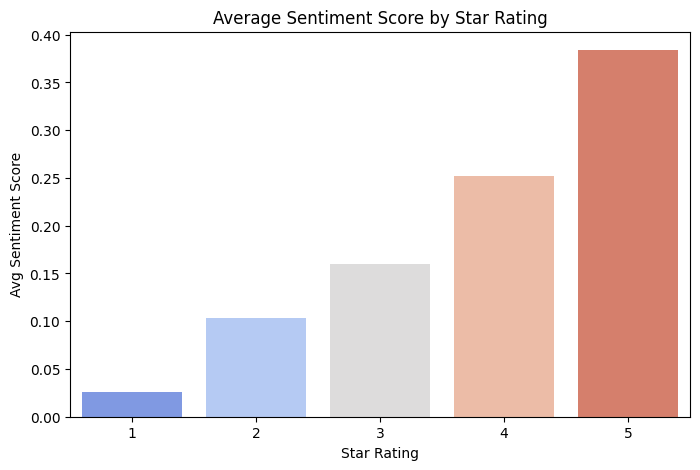

In [39]:
# group by star rating to get the mean sentiment score
sentiment_by_rating = product_reviews.groupby('rating')['sentiment_score'].mean().reset_index()

# plot the star rating vs sentiment scores
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_by_rating, x='rating', y='sentiment_score', palette='coolwarm')
plt.title('Average Sentiment Score by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Avg Sentiment Score')
plt.show()

Our plot is not what we would expect. We would expect that lower ratings such as 1 or 2 have negative sentiment scores. 3 stars should be around netural as we would expect mixed reviews. 4 and 5 stars should have a sent score above 0.2. 

Let's use a boxplot to get a clearer picture of the distribution to see why we may have gotten the results we did. 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


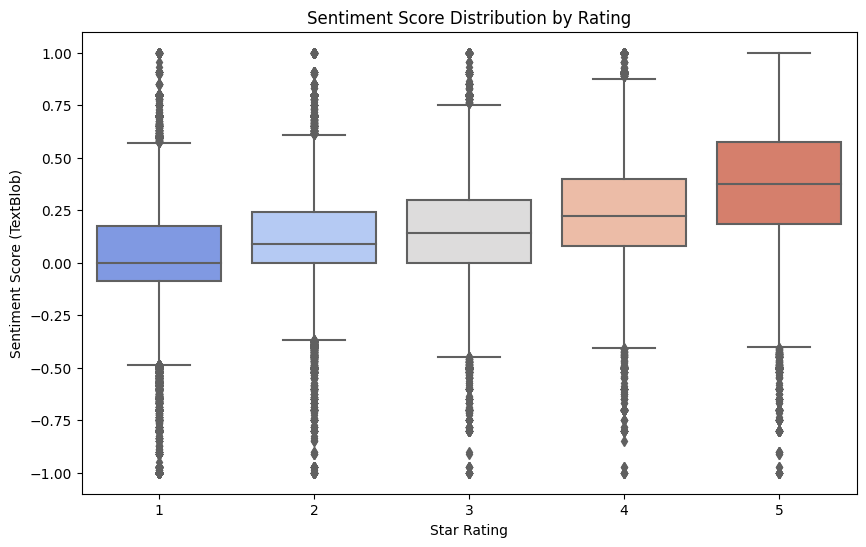

In [40]:
# plot sentiment distribution for ratings
plt.figure(figsize=(10, 6))
sns.boxplot(data=product_reviews, x='rating', y='sentiment_score', palette='coolwarm')
plt.title('Sentiment Score Distribution by Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score (TextBlob)')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


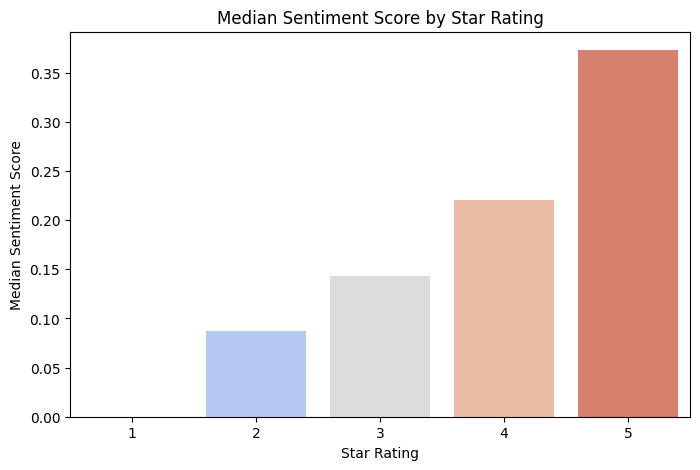

In [41]:
# let's compare the output to using the median score instead
# group by star rating to get the median sentiment score
sentiment_by_rating = product_reviews.groupby('rating')['sentiment_score'].median().reset_index()

# plot the star rating vs sentiment scores
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_by_rating, x='rating', y='sentiment_score', palette='coolwarm')
plt.title('Median Sentiment Score by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Median Sentiment Score')
plt.show()

## Topic Modeling by Rating or Category
To dig deeper into **what reviewers are actually talking about**, we used **Latent Dirichlet Allocation (LDA)** — an unsupervised NLP technique for discovering latent themes in large text to identify the most common topics discussed in:
- **Low-rated reviews (1–2 stars)** — potential complaints, frustrations, or product issues
- **High-rated reviews (4–5 stars)** — praise, satisfaction, or features customers love

This
- Reveals underlying **themes** in reviews that may not be captured by sentiment analysis alone
- Helps businesses understand **what drives negative or positive reviews**
- Surfaces **frequent complaints or points of praise** by rating group
- Can be used to generate **features** for machine learning models or guide product improvements

We expect low-rated reviews to include topics like “broken,” “late delivery,” or “refund,” and high-rated reviews to include themes like “perfect fit,” “great quality,” or “highly recommend.”

In [42]:
# load English model for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# ---- create functions ----
# tokenize
def tokenize(texts):
    return [simple_preprocess(str(doc), deacc=True) for doc in texts]

# lemmatization helper
def lemmatize(texts):
    output = []
    for doc in texts:
        doc_sp = nlp(" ".join(doc))
        output.append([
            token.lemma_ 
            for token in doc_sp 
            if token.pos_ in ['NOUN', 'ADJ', 'VERB']
        ])
    return output

In [43]:
# ---- process on dataset ----
# tokenize the cleaned text
data_words = tokenize(product_reviews['cleaned_text'])

In [44]:
# build bigram model & apply it
bigram = Phrases(data_words, min_count=5, threshold=100)
bigram_mod = Phraser(bigram)
data_words_bigrams = [bigram_mod[doc] for doc in data_words]

In [45]:
# remove custom stopwords
data_nostops = [
    [word for word in doc if word not in custom_stopwords] 
    for doc in data_words_bigrams
]

In [46]:
# lemmatize
data_lemmatized = lemmatize(data_nostops)

In [47]:
# print the first set 
data_lemmatized[0]

['buy',
 'think',
 'nice',
 'white',
 'background',
 'turn',
 'clear',
 'phone',
 'blue',
 'look',
 'know',
 'purchase',
 'work',
 'ok']

In [48]:
# filter 1-star and 5-star reviews
# Add lemmatized text as a new column
product_reviews['lemmatized'] = data_lemmatized

# Filter to only 1-star and 5-star reviews
one_star_reviews = product_reviews[product_reviews['rating'] == 1]
five_star_reviews = product_reviews[product_reviews['rating'] == 5]

In [49]:
# prepare data for Gensim LDA

# get tokenized data for each group
one_docs = one_star_reviews['lemmatized'].tolist()
five_docs = five_star_reviews['lemmatized'].tolist()

# create dictionary & corpus for 1-star
one_dict = Dictionary(one_docs)
one_corpus = [one_dict.doc2bow(doc) for doc in one_docs]

# create dictionary & corpus for 5-star
five_dict = Dictionary(five_docs)
five_corpus = [five_dict.doc2bow(doc) for doc in five_docs]

In [50]:
# train LDA Models
# Train LDA on 1-star reviews
lda_one = LdaModel(corpus=one_corpus,
                   id2word=one_dict,
                   num_topics=5,
                   random_state=42,
                   passes=10,
                   alpha='auto',
                   per_word_topics=True)

# Train LDA on 5-star reviews
lda_five = LdaModel(corpus=five_corpus,
                    id2word=five_dict,
                    num_topics=5,
                    random_state=42,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)

In [51]:
# view the top words in each topic
# Display topics
print("1-star review topics:")
for idx, topic in lda_one.print_topics(-1):
    print(f"Topic {idx}: {topic}")

print("\n5-star review topics:")
for idx, topic in lda_five.print_topics(-1):
    print(f"Topic {idx}: {topic}")

1-star review topics:
Topic 0: 0.136*"screen" + 0.073*"protector" + 0.027*"edge" + 0.021*"stick" + 0.020*"glass" + 0.019*"bubble" + 0.015*"touch" + 0.015*"cover" + 0.015*"crack" + 0.013*"install"
Topic 1: 0.036*"call" + 0.030*"seller" + 0.027*"refund" + 0.025*"contact" + 0.019*"hear" + 0.017*"support" + 0.015*"sound" + 0.014*"warranty" + 0.014*"tell" + 0.012*"send"
Topic 2: 0.089*"phone" + 0.057*"case" + 0.026*"work" + 0.021*"fit" + 0.013*"use" + 0.012*"iphone" + 0.011*"hold" + 0.011*"try" + 0.010*"put" + 0.008*"drop"
Topic 3: 0.035*"buy" + 0.029*"product" + 0.027*"use" + 0.025*"break" + 0.021*"time" + 0.019*"day" + 0.017*"month" + 0.016*"look" + 0.016*"return" + 0.016*"come"
Topic 4: 0.136*"charge" + 0.052*"watch" + 0.052*"charger" + 0.038*"battery" + 0.029*"work" + 0.024*"plug" + 0.023*"band" + 0.022*"cable" + 0.018*"stop" + 0.017*"apple"

5-star review topics:
Topic 0: 0.023*"use" + 0.023*"phone" + 0.016*"go" + 0.015*"take" + 0.015*"other" + 0.012*"little" + 0.010*"see" + 0.009*"fin

### Visualize Topics with pyLDAvis

In [52]:
# prepare the visualization
vis_one = gensimvis.prepare(lda_one, one_corpus, one_dict)

# display it (in Kaggle notebooks this should render inline)
pyLDAvis.display(vis_one)

Interpretation:
1. Left panel of circles - a circle represents a topic, and the size indicates the prevalence. Distance shows how distinct topics are.
2. Right panel of bar chart - when you click a top on the left, it shows its top words. Red bars are the most important. Blue bars are how common they are across the whole dataset. 

In [53]:
# do the same thing for the five-star ratings
vis_five = gensimvis.prepare(lda_five, five_corpus, five_dict)
pyLDAvis.display(vis_five)

### Common Words & Phrases - 1 vs 5 star reviews
To better understand the language used in extreme reviews, we compared the most distinctive terms in **1-star** and **5-star** reviews using **TF-IDF (Term Frequency–Inverse Document Frequency)**.

By comparing top TF-IDF words for each rating group, we can identify:
- Negative indicators (e.g., "broken", "refund") in 1-star reviews
- Positive indicators (e.g., "perfect", "love") in 5-star reviews

This helps validate that the language in reviews strongly correlates with their assigned ratings — and informs feature relevance for our classification models.

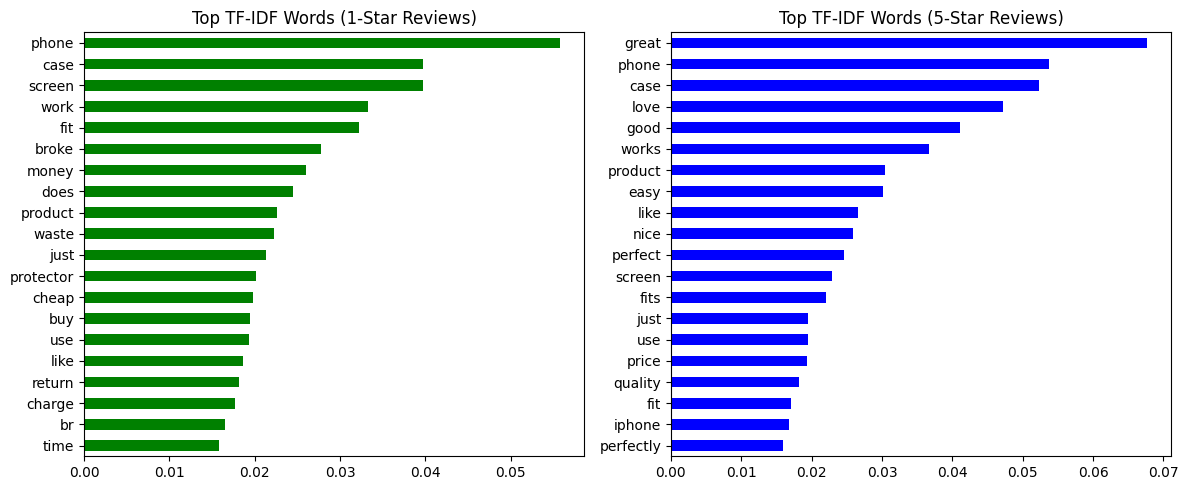

In [54]:
# Filter 1-star and 5-star reviews
one_star_reviews = product_reviews[product_reviews['rating'] == 1]['cleaned_text']
five_star_reviews = product_reviews[product_reviews['rating'] == 5]['cleaned_text']

# Combine them into one dataframe with labels
df = pd.concat([
    pd.DataFrame({'text': one_star_reviews, 'label': '1-star'}),
    pd.DataFrame({'text': five_star_reviews, 'label': '5-star'})
])

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['text'])

# Create a DataFrame of TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['label'] = df['label'].values

# Calculate mean TF-IDF score per word by rating
tfidf_means = tfidf_df.groupby('label').mean().T

# Find top words for each rating
top_1_star = tfidf_means['1-star'].sort_values(ascending=False).head(20)
top_5_star = tfidf_means['5-star'].sort_values(ascending=False).head(20)

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
top_1_star.plot(kind='barh', color='green')
plt.title("Top TF-IDF Words (1-Star Reviews)")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
top_5_star.plot(kind='barh', color='blue')
plt.title("Top TF-IDF Words (5-Star Reviews)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Sentiment Analysis vs Star Rating (Quantitative Comparison)
To understand how well **text sentiment** aligns with **user-assigned star ratings**, we performed a sentiment analysis using a pre-trained sentiment scoring tool.

- Assigned a **sentiment polarity score** to each review (ranging from negative to positive)
- Compared the **average sentiment scores** across different star ratings (1 through 5)
- Visualized the relationship between **computed sentiment** and **actual rating**

In [55]:
# correlation using
correlation, p_value = pearsonr(product_reviews['sentiment_score'], product_reviews['rating'])
print(f"Pearson correlation: {correlation:.2f}, p-value: {p_value:.4f}")

Pearson correlation: 0.42, p-value: 0.0000


In [56]:
# binary classification: high (4-5) vs low (1-2)
df = product_reviews[product_reviews['rating'].isin([1, 2, 4, 5])].copy()
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

X_train, X_test, y_train, y_test = train_test_split(df[['sentiment_score']], df['label'], test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

              precision    recall  f1-score   support

           0       0.69      0.17      0.27     15421
           1       0.85      0.98      0.91     76588

    accuracy                           0.85     92009
   macro avg       0.77      0.58      0.59     92009
weighted avg       0.83      0.85      0.81     92009



/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

## Summary
In this project, we explored how natural language processing can be used to predict **Amazon product review ratings** based on the review text.

### Takeaways:
- Review sentiment generally aligned with star ratings, though some 1-star reviews showed unexpectedly positive sentiment — suggesting labeling inconsistencies or external factors not reflected in the text.
- TF-IDF helped identify distinct vocabulary used in high- vs. low-rated reviews.
- Topic modeling (LDA) uncovered recurring themes in 1-star and 5-star reviews — providing qualitative insights into what drives customer satisfaction or frustration.
- Classification models like **Logistic Regression** and **Multinomial Naive Bayes** were used to predict review ratings, with moderate success despite class imbalance.

### Limitations:
- The dataset had a **class imbalance**, skewed toward higher ratings.
- Text alone doesn’t always capture the full context of a rating (e.g., product defects, shipping experience).
- No hyperparameter tuning or advanced deep learning models were used.

### Next Steps:
- Experiment with **balancing techniques** (e.g., SMOTE, class weighting)
- Incorporate **metadata features** (e.g., verified purchase, helpful votes, product category) to enrich the model

This project highlights how unstructured text can be transformed into meaningful insights — not only for building predictive models, but also for understanding customer voice at scale.